In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

### Define constants

In [55]:
DAYS_PER_YR = 365    # Number of days in one year

# set trip date. Set in 2018 as the dataset ends in 2017
Start_trip ="2018-05-01"
End_trip = "2018-05-15"



# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func,inspect

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [11]:
# check Measurement
engine.execute('SELECT * FROM Measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [12]:
inspector = inspect(engine)
columns = inspector.get_columns('Measurement')

for c in columns:
    print(c['name'], c["type"])


id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [13]:
all_data = engine.execute('SELECT * FROM Measurement').fetchall()
all_data[-1]
last_date = all_data[-1][2]
last_ind = all_data[-1][0]
print(last_date)
print(last_ind)

2017-08-23
19550


In [14]:
# check Station
engine.execute('SELECT * FROM Station LIMIT 5').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

In [15]:
inspector = inspect(engine)
columns = inspector.get_columns('Station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

### Design a query to retrieve the last 12 months of precipitation data and plot the results

1. Calculate the date 1 year ago from the last data point in the database

2. Perform a query to retrieve the data and precipitation scores

3. Save the query results as a Pandas DataFrame and set the index to the date column

4. Sort the dataframe by date

5. Use Pandas Plotting with Matplotlib to plot the data


#### 1. Calculate the date 1 year ago from the last data point in the database

In [16]:
tmp = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date = str(tmp)[2:12]

In [17]:
# get year,month and day of the last data
yr_last,mo_last,day_last = last_date.split("-")
print(f"yr_last={yr_last}")
print(f"mo_last={mo_last}")
print(f"day_last={day_last}")


yr_last=2017
mo_last=08
day_last=23


In [18]:
# get last_date in datetime format and compute the date 1 year ago
last_date = dt.datetime(int(yr_last), int(mo_last), int(day_last))
one_yr_b4_last_date = dt.datetime.date(last_date) - dt.timedelta(days= DAYS_PER_YR)
print(f"date one year before last date in database : {one_yr_b4_last_date}")


date one year before last date in database : 2016-08-23


#### 2. Perform a query to retrieve the data and precipitation scores for last 12 months

In [19]:
sel = [Measurement.date , 
       Measurement.prcp]

last_12mo_precipitation = session.query(*sel).\
    filter(Measurement.date >= one_yr_b4_last_date).\
    order_by(Measurement.date).all()

for i in range (10):
    print(last_12mo_precipitation[i])

('2016-08-23', 0.0)
('2016-08-23', 0.15)
('2016-08-23', 0.05)
('2016-08-23', None)
('2016-08-23', 0.02)
('2016-08-23', 1.79)
('2016-08-23', 0.7)
('2016-08-24', 0.08)
('2016-08-24', 2.15)
('2016-08-24', 2.28)


In [20]:
for i in range (10):
    print(last_12mo_precipitation[len(last_12mo_precipitation)-10+i])

('2017-08-21', 0.02)
('2017-08-21', None)
('2017-08-21', 0.56)
('2017-08-22', 0.0)
('2017-08-22', 0.0)
('2017-08-22', 0.5)
('2017-08-23', 0.0)
('2017-08-23', 0.0)
('2017-08-23', 0.08)
('2017-08-23', 0.45)


#### 3. Save the query results as a Pandas DataFrame and set the index to the date column

In [21]:
# Save the query results as a Pandas DataFrame and set the index to the date column
prec_df = pd.DataFrame(last_12mo_precipitation, columns=['date','precipitation' ])
prec_df.set_index('date', inplace=True)
prec_df.count()


precipitation    2021
dtype: int64

#### 4. Sort the dataframe by date

In [22]:
# Sort the dataframe by date
sort_prec_df=prec_df.sort_index(ascending=True)
sort_prec_df.head()

,precipitation
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02


#### 5. Use Pandas Plotting with Matplotlib to plot the data

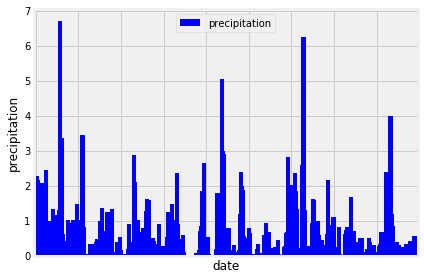

In [23]:
# Use Pandas Plotting with Matplotlib to plot the data
x_axis = np.arange(len(sort_prec_df))
precipitation = sort_prec_df['precipitation'].values.tolist()

plt.bar(x_axis,precipitation,color="b", align="center",label='precipitation', width=25)
plt.xlabel('date')
plt.ylabel('precipitation')
plt.legend(loc='upper center')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

plt.xlim(-10,len(precipitation)+10)
plt.tight_layout()
plt.savefig("precipitation.png")
plt.show()

In [24]:
# Use Pandas to calcualte the summary statistics for the precipitation data
sort_prec_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Station Analysis

#### 1. Design a query to show how many stations are available in this dataset?

In [25]:
number_station = session.query(Station.station).count()
print(f"Number of station = {number_station}")

Number of station = 9


#### 2. What are the most active stations? (i.e. what stations have the most rows)?
 List the stations and the counts in descending order.

In [26]:
# get station name
station_name= session.query(Station.station).all()

In [27]:
count_per_station = []
station_tmp = []

for i in range (len(station_name)):
    station=(str(station_name[i][0])) 
    count_per_station.append(session.query(Measurement.station).filter(Measurement.station == station).count())
    station_tmp.append(station)

print(station_tmp)
print(count_per_station)


['USC00519397', 'USC00513117', 'USC00514830', 'USC00517948', 'USC00518838', 'USC00519523', 'USC00519281', 'USC00511918', 'USC00516128']
[2724, 2709, 2202, 1372, 511, 2669, 2772, 1979, 2612]


In [28]:
station_df = pd.DataFrame(station_tmp)
station_df.columns = ['station']

station_df

,station
0,USC00519397
1,USC00513117
2,USC00514830
3,USC00517948
4,USC00518838
5,USC00519523
6,USC00519281
7,USC00511918
8,USC00516128


In [29]:
station_count_tmp = pd.DataFrame(count_per_station)
station_count_tmp.columns = ['count_of_measurements']
station_count_tmp

,count_of_measurements
0,2724
1,2709
2,2202
3,1372
4,511
5,2669
6,2772
7,1979
8,2612


##### Most active station is the station with the biggest number of measurements

In [30]:
station_count_df = station_df.join(station_count_tmp)
station_count_df

,station,count_of_measurements
0,USC00519397,2724
1,USC00513117,2709
2,USC00514830,2202
3,USC00517948,1372
4,USC00518838,511
5,USC00519523,2669
6,USC00519281,2772
7,USC00511918,1979
8,USC00516128,2612


In [32]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
most_active_station = station_count_df.loc[station_count_df['count_of_measurements']==max(count_per_station)]
most_active_station_id = most_active_station.iloc[0]['station']
print(f"The most active station ID is {most_active_station_id}")

The most active station ID is USC00519281


In [33]:
most_active_station_data = session.query(Measurement.station, \
                                        func.avg(Measurement.tobs),
                                        func.min(Measurement.tobs),
                                        func.max(Measurement.tobs)).  \
                           filter(Measurement.station == most_active_station_id).all()
print(f"Most active station ID: {most_active_station_data[0][0]}")
print(f"Average temperature of the most active station: {most_active_station_data[0][1]} deg F")
print(f"Lowest temperature recorded at most active station : {most_active_station_data[0][2]} deg F")
print(f"Highest temperature recorded at most active station : {most_active_station_data[0][3]} deg F")

Most active station ID: USC00519281
Average temperature of the most active station: 71.66378066378067 deg F
Lowest temperature recorded at most active station : 54.0 deg F
Highest temperature recorded at most active station : 85.0 deg F


#### Choose the station with the highest number of temperature observations.

In [34]:
count_per_station = []
station_tmp = []

for i in range (len(station_name)):
    station=(str(station_name[i][0])) 
    count_per_station.append(session.query(Measurement.tobs). \
                             filter(Measurement.station == station).\
                             filter(Measurement.date >= one_yr_b4_last_date).count())
    station_tmp.append(station)
    
for i in range (len(count_per_station)):
    if(max(count_per_station) == count_per_station[i]):
        most_temp_station_index = i

print(f"Station with the most temperation date: {station_tmp[most_temp_station_index]}")

Station with the most temperation date: USC00519397


In [35]:
station_tmp

['USC00519397',
 'USC00513117',
 'USC00514830',
 'USC00517948',
 'USC00518838',
 'USC00519523',
 'USC00519281',
 'USC00511918',
 'USC00516128']

In [36]:
count_per_station

[361, 343, 305, 183, 0, 337, 352, 0, 349]

#### Query the last 12 months of temperature observation data for this station ...
This question is not clear. I understood the histogram is drawn for the station with the most tobs data. 
Then the station to use is 'USC00519397'... and the histogram is not the same as the one shown in the readme.md

In [37]:
target_index = most_temp_station_index
target_station = station_tmp[target_index]

temperature_last_year_data_most_active = session.query(Measurement.date,\
                                        Measurement.tobs).  \
                           filter(Measurement.station == target_station). \
                           filter(Measurement.date >= one_yr_b4_last_date).\
                        order_by(Measurement.date).all()
temperature_last_year_data_most_active_df = pd.DataFrame(temperature_last_year_data_most_active)
temperature_last_year_data_most_active_df.count()

date    361
tobs    361
dtype: int64

In [38]:
temperature_last_year_data_most_active_df.dropna().head()

,date,tobs
0,2016-08-23,81.0
1,2016-08-24,79.0
2,2016-08-25,80.0
3,2016-08-26,79.0
4,2016-08-27,77.0


#### ... and plot the results as a histogram

In [39]:
temp_min=temperature_last_year_data_most_active_df[['tobs']].min()
temp_max=temperature_last_year_data_most_active_df[['tobs']].max()

print(f"min temp = {temp_min[0]}")
print(f"max temp = {temp_max[0]}")

min temp = 60.0
max temp = 87.0


In [40]:
temp = temperature_last_year_data_most_active_df['tobs'].values.tolist()
temp[0:10]

[81.0, 79.0, 80.0, 79.0, 77.0, 78.0, 78.0, 79.0, 80.0, 81.0]

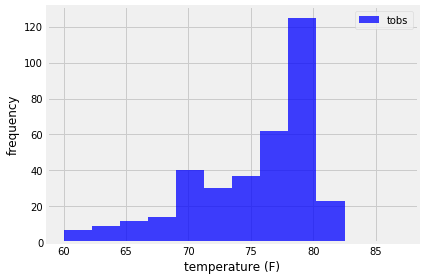

In [42]:
num_bins =12

plt.hist(temp,num_bins, facecolor='blue', alpha=0.75,label='tobs')
plt.ylabel('frequency')
plt.legend(loc='upper right')
plt.xlabel('temperature (F)')
plt.tight_layout()
plt.savefig("station_most_tobs.png")
plt.show()

#### To get the right histogram, the station to use is most_active_station

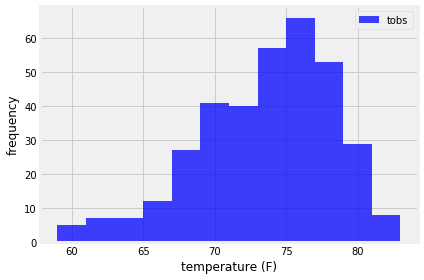

In [43]:
target_station = most_active_station_id

temperature_last_year_data_most_active = session.query(Measurement.date,\
                                        Measurement.tobs).  \
                           filter(Measurement.station == target_station). \
                           filter(Measurement.date >= one_yr_b4_last_date).\
                        order_by(Measurement.date).all()

temperature_last_year_data_most_active_df = pd.DataFrame(temperature_last_year_data_most_active)
temp = temperature_last_year_data_most_active_df['tobs'].values.tolist()

plt.hist(temp,num_bins, facecolor='blue', alpha=0.75,label='tobs')
plt.ylabel('frequency')
plt.legend(loc='upper right')
plt.xlabel('temperature (F)')
plt.tight_layout()
plt.savefig("station_most_active.png")
plt.show()


In [44]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [45]:
# get previous year date
yr_last,mo_last,day_last = Start_trip.split("-")
Start_trip_previous_yr = dt.datetime(int(yr_last)-1, int(mo_last), int(day_last))

yr_last,mo_last,day_last = End_trip.split("-")
End_trip_previous_yr = dt.datetime(int(yr_last)-1, int(mo_last), int(day_last))

In [46]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
tmp=calc_temps(Start_trip_previous_yr,End_trip_previous_yr)
tmin = tmp[0][0]
tave = round(tmp[0][1]*100)/100
tmax = tmp[0][2]

print(f"min temperature = {tmin} deg F")
print(f"max temperature = {tmax} deg F")
print(f"average temperature = {tave} deg F")

min temperature = 66.0 deg F
max temperature = 80.0 deg F
average temperature = 75.49 deg F


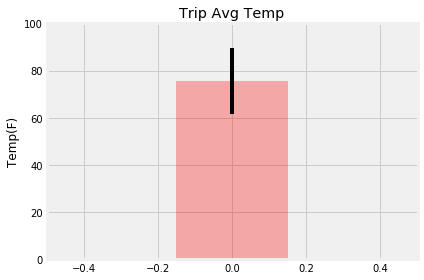

In [48]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
yerr = tmax-tmin
y = tave

plt.bar(0,y,yerr= tmax-tmin, color="red", align="center",width =0.3,alpha=0.3)
plt.title("Trip Avg Temp")
plt.ylabel("Temp(F)")
plt.xlim(-0.5,0.5)
plt.ylim(0,100)

plt.tight_layout()
plt.savefig("Trip_Avg_Temp.png")
plt.show()

In [58]:
Start_trip

'2018-05-01'

In [64]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

results= session.query(Measurement.date,\
              Measurement.prcp, 
              Measurement.station).  \
              filter(Measurement.date >= Start_trip_previous_yr).\
              filter(Measurement.date <= End_trip_previous_yr).\
                        order_by(Measurement.date).all()
results[0:10]

[('2017-05-02', 0.0, 'USC00519397'),
 ('2017-05-02', 0.03, 'USC00513117'),
 ('2017-05-02', 0.01, 'USC00514830'),
 ('2017-05-02', 0.0, 'USC00519523'),
 ('2017-05-02', 0.01, 'USC00519281'),
 ('2017-05-02', 0.0, 'USC00516128'),
 ('2017-05-03', 0.0, 'USC00519397'),
 ('2017-05-03', 0.01, 'USC00513117'),
 ('2017-05-03', 0.01, 'USC00514830'),
 ('2017-05-03', 0.0, 'USC00519523')]

In [67]:
results_df = pd.DataFrame(results)

results_df.head()

,date,prcp,station
0,2017-05-02,0.00,USC00519397
1,2017-05-02,0.03,USC00513117
2,2017-05-02,0.01,USC00514830
3,2017-05-02,0.00,USC00519523
4,2017-05-02,0.01,USC00519281


In [71]:
amount_precipitation_per_station = results_df.groupby('station').sum()
amount_precipitation_per_station

,prcp
station,
USC00513117,2.22
USC00514830,1.91
USC00516128,4.26
USC00519281,3.07
USC00519397,0.06
USC00519523,0.80


In [74]:
amount_precipitation_per_station

['T',
 '_AXIS_ALIASES',
 '_AXIS_IALIASES',
 '_AXIS_LEN',
 '_AXIS_NAMES',
 '_AXIS_NUMBERS',
 '_AXIS_ORDERS',
 '_AXIS_REVERSED',
 '_AXIS_SLICEMAP',
 '__abs__',
 '__add__',
 '__and__',
 '__array__',
 '__array_priority__',
 '__array_wrap__',
 '__bool__',
 '__bytes__',
 '__class__',
 '__contains__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__div__',
 '__doc__',
 '__eq__',
 '__finalize__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__iand__',
 '__ifloordiv__',
 '__imod__',
 '__imul__',
 '__init__',
 '__init_subclass__',
 '__invert__',
 '__ior__',
 '__ipow__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__ixor__',
 '__le__',
 '__len__',
 '__lt__',
 '__matmul__',
 '__mod__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__nonzero__',
 '__or__',
 '__pos__',
 '__pow__',
 '__radd__',
 '__rand__',
 '__rdiv__',
 '__reduce__',

## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)
 
def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
